<a href="https://colab.research.google.com/github/10erick-cpu/Entregas/blob/main/TP8/TP8_Trabajo_Pr%C3%A1ctico_VIII_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Trabajo Práctico VIII**

Implementar un aplicativo que permita abrir una imagen y con esta obtener:

• **Downsampling X2** (mostrando la imagen resultada al doble de tamaño para comparar el efecto) utilizando kernel constante, bilineal, y bicúbico.

• **Upsampling X2** (mostrando la imagen original al doble de tamaño para comparar el efecto) utilizando kernel constante, bilineal, y bicúbico.

• **Cuantización** a cantidad de niveles de gris variable, utilizando uniforme, dithering aleatorio, y difusión del error por scan-line.

Todas las funciones de Downsamplig, Upsampling y Cuantización deben ser desarrolladas como funciones propias y NO con funciones de biblioteca. Les sugiero recorrer la imagen mediante ciclos for anidados para una fácil implementación.

### **Alumno** : Erick Macote Yparraguirre
### **mail** : leonelerick59@gmail.com
### **Profesor** : Steven Martinez Vargas


In [97]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Librerias Usadas**

In [98]:
import matplotlib.pyplot as plt 
import numpy as np
import imageio as io
from scipy import fftpack
import numpy.fft
import numpy.fft as fp
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

import math
import sys
import time
import random

# **Función para leer la imágen y mostrarla**

(320, 480, 3) <class 'numpy.ndarray'>


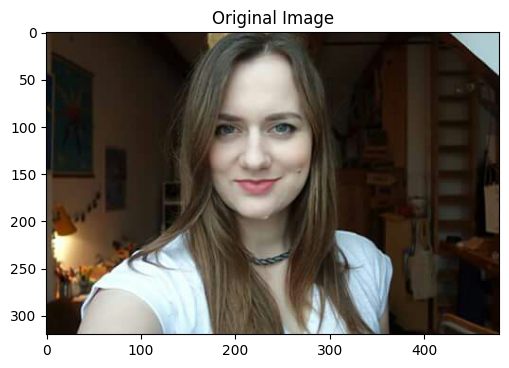

In [99]:
### Función para leer la Imagen y convertirlo en array ###

def read_ima(path):
    ima = np.asarray(Image.open(path))
    print(ima.shape, type(ima))
    return ima

### Función para leer los canales RGB ###

def channels_ima(ima):
    r, g, b = ima[:, :, 0], ima[:, :, 1], ima[:, :, 2]
    return r, g, b

# r,g,b= channels_ima(im_a)
# print(r,g,b)


## Defino el path ##

path1='/content/Czech.jpeg'

## Leemos la Imagen en función del path ##

ima1 = read_ima(path1)

### Graficamos la imagen 1 ###

def plot_image(im, title, cmap=None):
  fig, ax = plt.subplots(dpi=100)
  ax.imshow(im, cmap=cmap)
  ax.set_title(title)
  plt.axis('on')
  plt.show()

plot_image(ima1,title='Original Image')

#**Convertimos cada pixel de la imagen del espacio RGB al espacio YIQ para trabajar con la Luminancia**

In [100]:
### Función para leer los canales RGB - Normalizamos para pasar de RGB a YIQ ###

def channels_ima(ima):
    r, g, b = ima[:, :, 0]/255.0, ima[:, :, 1]/255.0, ima[:, :, 2]/255.0
    return r, g, b

ra,ga,ba = channels_ima(ima1)


### Funciones para trabajar en los espacios RGB - YIQ -- Canales independientes ##

def trans_rgb_to_yiq(r,g,b):
    y= 0.299*r + 0.587*g + 0.114*b
    i= 0.595716*r - 0.274453*g - 0.321263*b
    q= 0.211456*r - 0.522591*g + 0.311135*b 
    return y,i,q

def trans_yiq_to_rgb(y,i,q):
    r= ( y + 0.9663*i + 0.6210*q)*255.0
    g= (y - 0.2721*i - 0.6474*q)*255.0
    b= (y - 1.1070*i + 1.7046*q)*255.0
    return clip_rgb(r,g,b)

####  Funciones para Clipear los espacios YIQ & RGB ####

def clip_rgb(r,g,b): 
  r=np.clip(r,0,255)
  g=np.clip(g,0,255)
  b=np.clip(g,0,255)
  return r,g,b

def clip_yiq(y,i,q):
  y=np.clip(y,0,1)
  i=np.clip(i,-0.5957,0.5957)
  q=np.clip(q,-0.5226,0.5226)
  return y,i,q

# **Valores de Ya Ia Qa - Imágen A**

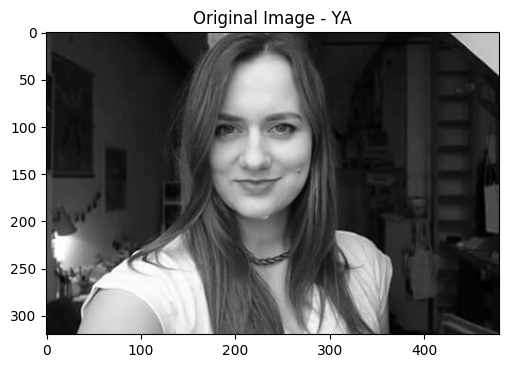

In [101]:
### Valores de Y I Q , para la imagen A

Ra,Ga,Ba = clip_rgb(ra,ga,ba)

#### Trasformacion del Espacio RGB al Espacio YIQ  ####

Ya,Ia,Qa = trans_rgb_to_yiq(Ra,Ga,Ba)

# Ya,Ia,Qa = trans_rgb_to_yiq(ra,ga,ba)

YA,IA,QA = clip_yiq(Ya,Ia,Qa)

# Obtenemos la Luminancia

YA

# Ploteamos la Luminancia 

plot_image(YA ,title='Original Image - YA',cmap='gray')



# **Downsampling X2**

Mostrando la imagen resultada al doble de tamaño para comparar el efecto) utilizando kernel constante, bilineal, y bicúbico.

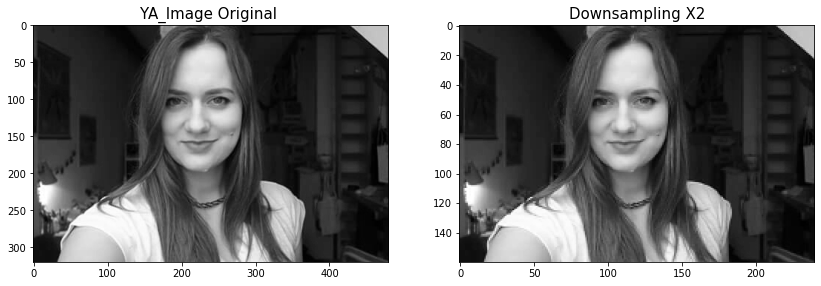

In [102]:
# Dimensiones de la imagen original

[m,n] = YA.shape

# Downsampling
  
# Asignamos un frecuencia de muestreo de downsampling a la imagen en 2

f = 2
  
# Creamos una matriz de ceros para valores reducidos

img2 = np.zeros((m//f, n//f), dtype=float)
  
for i in range(0, m, f):
    for j in range(0, n, f):
        try:
              img2[i//f][j//f] = YA[i][j]
        except IndexError:
            pass
  
# Ploteamos imagenes  

titles = ['YA_Image Original ', 'Downsampling X2'] 
images = [YA,img2] 

plt.figure(figsize=(14,10))
for i in range(2): 
  plt.subplot(2,2,i+1), plt.imshow(images[i],'gray'),
  plt.title(titles[i],fontsize=15) 
  # plt.xticks([]),plt.yticks([]) 
plt.show()


# **kernel bilinear**

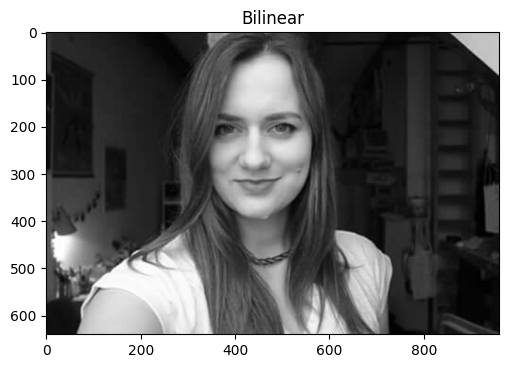

In [104]:
# definimos la funcion bilineal


def bl_resize(original_img, new_h, new_w):
	
# Dimensiones - Imagen original
	old_h, old_w = original_img.shape
	
	resized = np.zeros((new_h, new_w), dtype=float)
 
# calculamos el factor de escala horizontal y vertical

	w_scale_factor = (old_w ) / (new_w ) if new_h != 0 else 0
	h_scale_factor = (old_h ) / (new_h ) if new_w != 0 else 0
	for i in range(new_h):
		for j in range(new_w):
    
# mapeo de coordenadas 
			x = i * h_scale_factor
			y = j * w_scale_factor

# Calculamos los valores de las coordenadas para 4 píxeles vecinos

			x_floor = math.floor(x)
			x_ceil = min( old_h - 1, math.ceil(x))
			y_floor = math.floor(y)
			y_ceil = min(old_w - 1, math.ceil(y))

			if (x_ceil == x_floor) and (y_ceil == y_floor):
				q = original_img[int(x), int(y)]
			elif (x_ceil == x_floor):
				q1 = original_img[int(x), int(y_floor)]
				q2 = original_img[int(x), int(y_ceil)]
				q = q1 * (y_ceil - y) + q2 * (y - y_floor)
			elif (y_ceil == y_floor):
				q1 = original_img[int(x_floor), int(y)]
				q2 = original_img[int(x_ceil), int(y)]
				q = (q1 * (x_ceil - x)) + (q2	 * (x - x_floor))
			else:
				v1 = original_img[x_floor, y_floor]
				v2 = original_img[x_ceil, y_floor]
				v3 = original_img[x_floor, y_ceil]
				v4 = original_img[x_ceil, y_ceil]

				q1 = v1 * (x_ceil - x) + v2 * (x - x_floor)
				q2 = v3 * (x_ceil - x) + v4 * (x - x_floor)
				q = q1 * (y_ceil - y) + q2 * (y - y_floor)

			resized[i,j] = q
	return resized.astype(np.float)
 
 # otorgamos dimensiones deseadas

resized = bl_resize(YA, 640, 960)

# Ploteamos

plot_image(resized,title='Bilinear',cmap='gray')

# **Bilinear con Open CV solo para comparación**

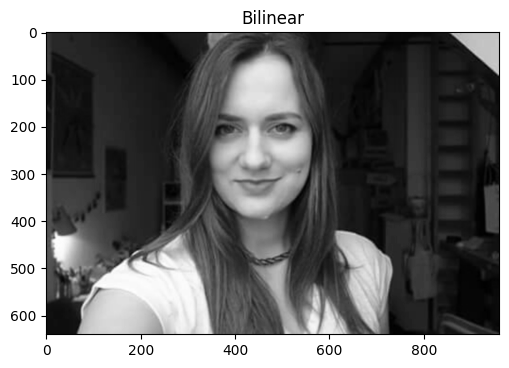

In [105]:
import cv2

img = cv2.imread("/content/Czech.jpeg",0)
resized1 = cv2.resize(img, (960,640), interpolation=cv2.INTER_LINEAR)

plot_image(resized1,title='Bilinear',cmap='gray')

# **Kernel Bicubic**

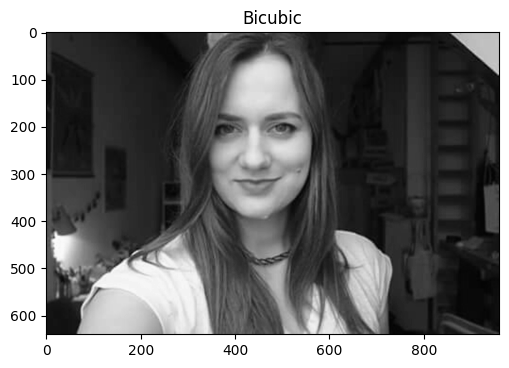

In [108]:

# Definimos funcion Kernel de Interpolacion
  
def u(s, a):
    if (abs(s) >= 0) & (abs(s) <= 1):
        return (a+2)*(abs(s)**3)-(a+3)*(abs(s)**2)+1
    elif (abs(s) > 1) & (abs(s) <= 2):
        return a*(abs(s)**3)-(5*a)*(abs(s)**2)+(8*a)*abs(s)-4*a
    return 0
  
  
# Funcion Padding

def padding(img, H, W):
    zimg = np.zeros((H+4, W+4))
    zimg[2:H+2, 2:W+2] = img
      
# Rellenamos las dos primeras / últimas columnas y filas

    zimg[2:H+2, 0:2 ] = img[:, 0:1]
    zimg[H+2:H+4, 2:W+2] = img[H-1:H]
    zimg[2:H+2, W+2:W+4] = img[:, W-1:W]
    zimg[0:2, 2:W+2] = img[0:1, :]
      
# completo los puntos que faltan

    zimg[0:2, 0:2] = img[0, 0]
    zimg[H+2:H+4, 0:2] = img[H-1, 0,]
    zimg[H+2:H+4, W+2:W+4] = img[H-1, W-1]
    zimg[0:2, W+2:W+4] = img[0, W-1]
    return zimg
  
  
# Funcion de operacion Bicubica

def bicubic(img, ratio, a):
    
# Dimensiones de la imagen

    H, W = img.shape
      
    img = padding(img, H, W)
      
# Creamos una nueva imagen

    dH = math.floor(H*ratio)
    dW = math.floor(W*ratio)
  
# Generamos una matriz de ceros
    dst = np.zeros((dH, dW))  
    
    h = 1/ratio
  
    inc = 0
    for j in range(dH):
            for i in range(dW):
                
# Coordenadas de los valores cercanos
                x, y = i * h + 2, j * h + 2
  
                x1 = 1 + x - math.floor(x)
                x2 = x - math.floor(x)
                x3 = math.floor(x) + 1 - x
                x4 = math.floor(x) + 2 - x
  
                y1 = 1 + y - math.floor(y)
                y2 = y - math.floor(y)
                y3 = math.floor(y) + 1 - y
                y4 = math.floor(y) + 2 - y
                  
# # Considering valores cercanos (16)

                mat_l = np.matrix([[u(x1, a), u(x2, a), u(x3, a), u(x4, a)]])
                mat_m = np.matrix([[img[int(y-y1), int(x-x1)],
                                    img[int(y-y2), int(x-x1)],
                                    img[int(y+y3), int(x-x1)],
                                    img[int(y+y4), int(x-x1)]],
                                   [img[int(y-y1), int(x-x2)],
                                    img[int(y-y2), int(x-x2)],
                                    img[int(y+y3), int(x-x2)],
                                    img[int(y+y4), int(x-x2)]],
                                   [img[int(y-y1), int(x+x3)],
                                    img[int(y-y2), int(x+x3)],
                                    img[int(y+y3), int(x+x3)],
                                    img[int(y+y4), int(x+x3)]],
                                   [img[int(y-y1), int(x+x4)],
                                    img[int(y-y2), int(x+x4)],
                                    img[int(y+y3), int(x+x4)],
                                    img[int(y+y4), int(x+x4)]]])
                mat_r = np.matrix(
                    [[u(y1, a)], [u(y2, a)], [u(y3, a)], [u(y4, a)]])
                  
# Producto escalar de las matrices
                dst[j, i] = np.dot(np.dot(mat_l, mat_m), mat_r)
  
    
    return dst
    
# Factor de escala

ratio = 2

# Coeficiente

a = -1/2
  
# Ingresamos la imagen original ( YA ) en la funcion cubica 

dst = bicubic(YA, ratio, a)

# Ploteamos

plot_image(dst,title='Bicubic',cmap='gray')

# **Bicubic con Open CV solo para comparación**

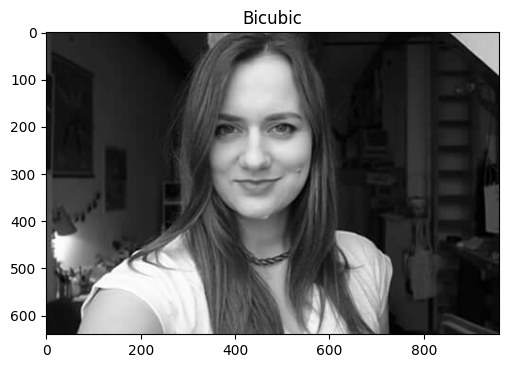

In [109]:

img10 = cv2.imread("/content/Czech.jpeg",0)
resized10 = cv2.resize(img10, (960,640), interpolation=cv2.INTER_CUBIC)

plot_image(resized10,title='Bicubic',cmap='gray')

#**Upsampling X2**

Mostrando la imagen original al doble de tamaño para comparar el efecto utilizando kernel constante, bilineal, y bicúbico.

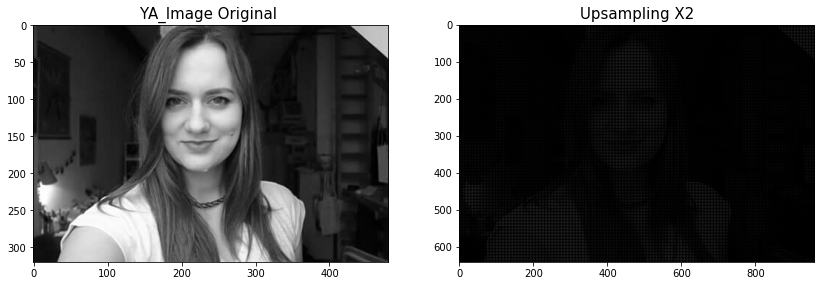

In [16]:
# Dimensiones de la Imagen original

[m,n] = YA.shape


# Upsampling
  
# Frecuencia de muestreo

f = 2
  
# Matriz de ceros para los valores Upsampling

img4 = np.zeros((m*f,n*f), dtype=np.float)
  

for i in range(0, m, f):
    for j in range(0, n, f):
        try:
              img4[i*f+1][j*f] = YA[i][j]
        except IndexError:
            pass


# Ploteamos imagenes  

titles = ['YA_Image Original ', 'Upsampling X2'] 
images = [YA,img4] 

plt.figure(figsize=(14,10))
for i in range(2): 
  plt.subplot(2,2,i+1), plt.imshow(images[i],'gray'),
  plt.title(titles[i],fontsize=15) 
  # plt.xticks([]),plt.yticks([]) 
plt.show()





# **Ploteos - Otra forma / Downsampling/Upsampling**


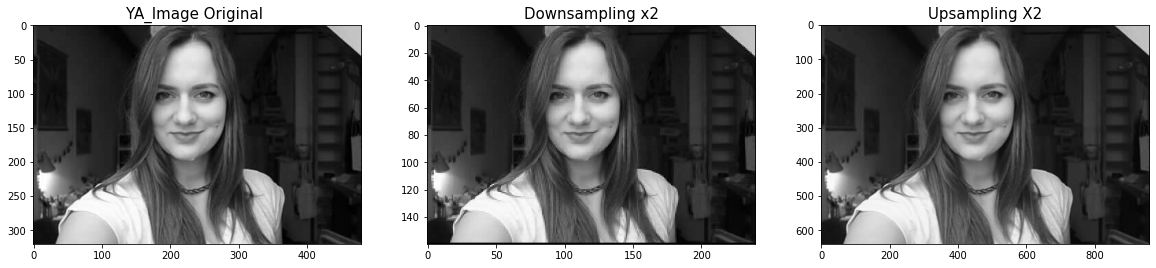

In [17]:
from scipy.ndimage import zoom

up = zoom(YA,2) #upsample image
down = zoom(YA,0.5) #downsample the upsampled image

# Ploteamos imagenes  

titles = ['YA_Image Original ', 'Downsampling x2','Upsampling X2'] 
images = [YA,down,up] 

plt.figure(figsize=(20,16))
for i in range(3): 
  plt.subplot(3,3,i+1), plt.imshow(images[i],'gray'),
  plt.title(titles[i],fontsize=15) 
  # plt.xticks([]),plt.yticks([]) 
plt.show()

# **Cuantización**

A cantidad de niveles de gris variable, utilizando uniforme, dithering aleatorio, y difusión del error por scan-line.

# **Niveles de Gris Variable**

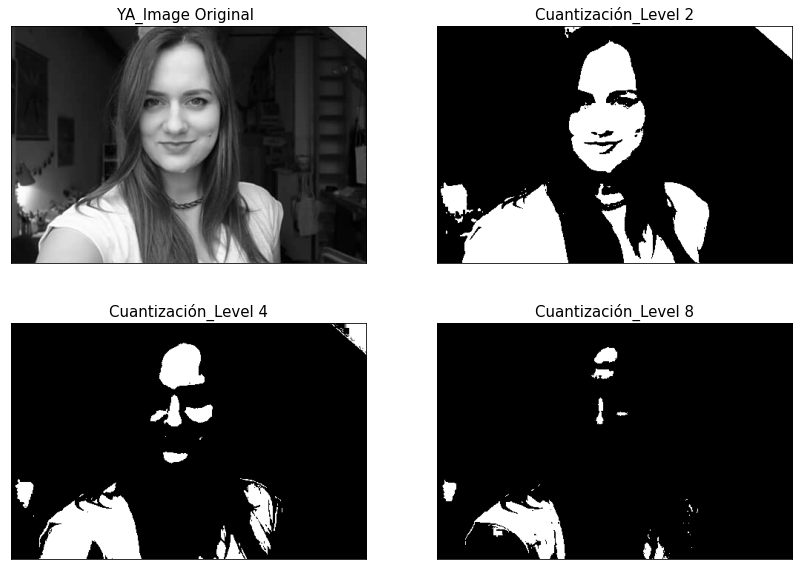

In [68]:
 YA

 YA = cv2.imread('Czech.jpeg',0) # Escala de grises

# Dimensiones de la imagen

height = YA.shape[0]
width = YA.shape[1]


# Creamos un nueva imagen 

new_img1 = np.zeros((height, width), np.uint8)

# Cuantización - Nivel de cuantificación - 2

for i in range(height):
  for j in range(width):
    if YA[i,j] < 128:
      gray = 0
    else:
      gray = 128
      new_img1[i,j] = np.uint8(gray)


# Cuantización - Nivel de cuantificación - 4

new_img2 = np.zeros((height, width), np.uint8)

for i in range(height):
  for j in range(width):
    if YA[i, j] < 64:
      gray = 0
    elif YA[i, j] < 128:
      gray = 64
    elif YA[i, j] < 192:
      gray = 128
    else:
      gray = 192
      new_img2[i, j] = np.uint8(gray)

# Cuantización - Nivel de cuantificación - 8

new_img3 = np.zeros((height, width), np.uint8)

for i in range(height):
  for j in range(width):
    if YA[i, j] < 32:
      gray = 0
    elif YA[i, j] < 64:
      gray = 32
    elif YA[i, j] < 96:
      gray = 64
    elif YA[i, j] < 128:
      gray = 96
    elif YA[i, j] < 160:
      gray = 128
    elif YA[i, j] < 192:
      gray = 160
    elif YA[i, j] < 224:
      gray = 192
    else:
      gray = 224
      new_img3[i, j] = np.uint8(gray)

# Ploteamos imagenes  


titles = ['YA_Image Original ', 'Cuantización_Level 2', 'Cuantización_Level 4', 'Cuantización_Level 8'] 
images = [YA, new_img1, new_img2, new_img3] 

plt.figure(figsize=(14,10))
for i in range(4): 
  plt.subplot(2,2,i+1), plt.imshow(images[i],'gray'),
  plt.title(titles[i],fontsize=15) 
  plt.xticks([]),plt.yticks([]) 
plt.show()




#**Dithering aleatorio**

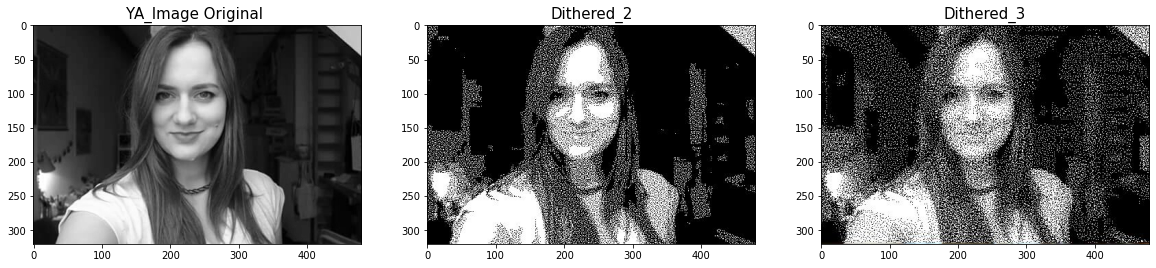

In [110]:
from PIL import Image
import random

im = Image.open("/content/Czech.jpeg") 

new = im.copy()
pix = im.load()

newpix = new.load()
width,height=im.size
# print([width,height])
# print(pix[1,1])

window = 2 # parametro de entrada ( n = 2, n = 3)

for window in range(2, 4):
  area = window*window
for i in range(width//window):     #loop sobre los  pixels
    for j in range(height//window):#loop sobre pixels
        avg = 0
        area_pix = []
        for k in range(window):
            for l in range(window):
                area_pix.append((k,l))# Armamos una lista de coordenadas
                try:
                    avg += pix[window*i+k,window*j+l][0] 
                    newpix[window*i+k,window*j+l] = (0,0,0) #seteamos a negro
                except IndexError:
                    avg += 255/2 # valor medio arbitrario
        avg = avg/area
        # val = v is the number of pixels within the tile that will be turned white

        val = round(avg/255 * (area+0.99) - 0.5)#0,99 debido a errores de redondeo
        assert val<=area,'something went wrong with the val'
        # print(val)
        random.shuffle(area_pix) #aleatorio coordenadas de píxeles
        for m in range(val):
            rel_coords = area_pix.pop()#Buscar píxeles aleatorios y convertirlo en blanco
            newpix[window*i+rel_coords[0],window*j+rel_coords[1]] = (255,255,255)


# Guardamos la Imagen para  n = 2 , n = 3

new.save('Czech_dithered'+str(window)+'.jpg')

# Mostramos la imagen para n = 2

im_dith2 = Image.open("/content/Czech_dithered2.jpg") 

# plt.imshow(im_dith2, cmap="gray")


# Mostramos la imagen para n = 2

im_dith3 = Image.open("/content/Czech_dithered3.jpg") 

# plt.imshow(im_dith3, cmap="gray")


# Ploteamos imagenes  

titles = ['YA_Image Original ', 'Dithered_2','Dithered_3'] 
images = [YA,im_dith2,im_dith3 ] 


plt.figure(figsize=(20,22))
for i in range(3): 
  plt.subplot(3,3,i+1), plt.imshow(images[i],'gray'),
  plt.title(titles[i],fontsize=15) 
  # plt.xticks([]),plt.yticks([]) 
plt.show()